# Results

In [1]:
require('cowplot')
library('ggplot2')
source('get_expected_pval_and_equiv_z.R')
source('multiplot.R')
source('plot_lib.R')
theme_set(theme_gray()) # switch to default ggplot2 theme for good

Loading required package: cowplot
Loading required package: ggplot2

Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave



#### Load data from the CSV files

##### One-sample

In [2]:
allsimudat_btw0 <- load_data_from_csv('^test1_.*btw0_.*')
allsimudat_btw1 <- load_data_from_csv('^test1_.*btw1_.*')
allsimudat <- rbind(allsimudat_btw0, allsimudat_btw1)

##### Two-sample

In [3]:
allsimudat2_btw0 <- load_data_from_csv('^test2_.*btw0_.*')
allsimudat2_btw1 <- load_data_from_csv('^test2_.*btw1_.*')
allsimudat2 <- rbind(allsimudat2_btw0, allsimudat2_btw1)

In [4]:
unique(allsimudat2_btw0$glm)

[1] 2

##### Unbalanced two-sample

In [5]:
source('get_expected_pval_and_equiv_z.R')
allsimudat3_btw0 <- load_data_from_csv('^test3_.*btw0_.*')
allsimudat3_btw1 <- load_data_from_csv('^test3_.*btw1_.*')
allsimudat3 <- rbind(allsimudat3_btw0, allsimudat3_btw1)

[1] "pattern= test3_btw0_"
[1] "CSV file /Users/cmaumet/Projects/Meta-analysis/dev/zmeta/Scripts/simulations/lib/../../../data/allsimudat_test3_btw0_.csv  not found, reprocessing the data."
[1] "^test3_.*btw0_.*"
[1] "84 simulations"
[1] "Reading  84  /  84"
[1] "/Volumes/camille/IBMA_simu//test3_k5_btw0_wth80_nominal/simu_400.csv"
[1] "saved in /Users/cmaumet/Projects/Meta-analysis/dev/zmeta/Scripts/simulations/lib/../../../data/allsimudat_test3_btw0_.csv"
[1] "Reading  83  /  84"
[1] "/Volumes/camille/IBMA_simu//test3_k5_btw0_wth80_datascl_soft50_100/simu_400.csv"
[1] "saved in /Users/cmaumet/Projects/Meta-analysis/dev/zmeta/Scripts/simulations/lib/../../../data/allsimudat_test3_btw0_.csv"
[1] "Reading  82  /  84"
[1] "/Volumes/camille/IBMA_simu//test3_k5_btw0_wth80_datascl_soft50_002/simu_400.csv"
[1] "saved in /Users/cmaumet/Projects/Meta-analysis/dev/zmeta/Scripts/simulations/lib/../../../data/allsimudat_test3_btw0_.csv"
[1] "Reading  81  /  84"
[1] "/Volumes/camille/IBMA_simu//te

### 1. Robustness to units mismatch

We look how contrast-based methods are affected by the units issue.

In [6]:
con_methods <- c("megaMFX","megaRFX","permutCon", "megaFFX_FSL")
con_data_1 <- subset(allsimudat, is.finite(expectedz) & expectedz>0  &  methods %in% con_methods)
con_data_2 <- subset(allsimudat2, is.finite(expectedz) & expectedz>0 & methods %in% con_methods)
con_data_3 <- subset(allsimudat3, is.finite(expectedz) & expectedz>0 & methods %in% con_methods)

##### Plots

###### Units mismtach

We look at the best case scenario for each contrast-based method:
 - MFX GLM: τ2 ≠ 0 -> τ2 = 1
 - RFX GLM: σ2/n constant for all studies
 - Contrast Permutation: anything
 - FFX GLM: τ2 = 0

In [7]:
best_con_data_1 <- subset(con_data_1, 
    ((methods %in% c("megaMFX") & Between==1) | 
     (methods %in% c("megaRFX"))  | 
     (methods %in% c("megaFFX_FSL") & Between==0) |
     (methods %in% c("permutCon"))
    ) & nStudies==25)
best_con_data_2 <- subset(con_data_2, 
    ((methods %in% c("megaMFX") & Between==1) | 
     (methods %in% c("megaRFX"))  | 
     (methods %in% c("megaFFX_FSL") & Between==0) |
     (methods %in% c("permutCon"))
    ) & nStudies==50)
best_con_data_3 <- subset(con_data_3, 
    ((methods %in% c("megaMFX") & Between==1) | 
     (methods %in% c("megaRFX"))  | 
     (methods %in% c("megaFFX_FSL") & Between==0) |
     (methods %in% c("permutCon"))
    ) & nStudies==50)

#### One-sample tests

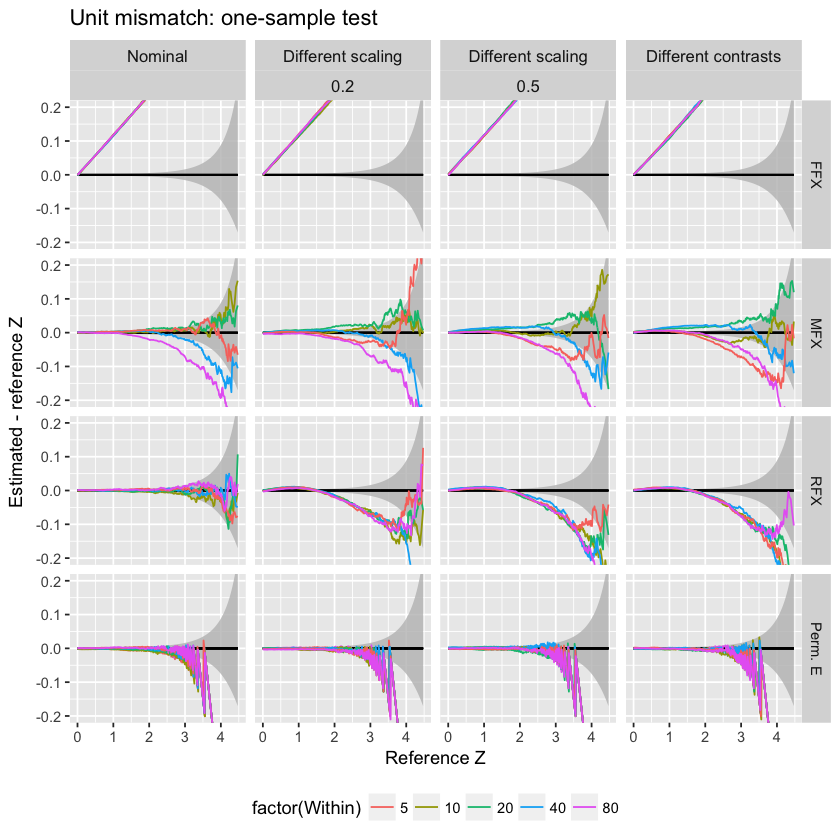

In [8]:
source('plot_lib.R')
source('prepare_data.R')
source('plot_unit_mismatch.R')
source('plot_blandaldman_z.R')
# Note for RFX we only keep btw=1 for display purposes (results with btw=0 are very similar)
# Also we only keep z>4.5 (to avoid very variable tail affecting ylim)
plot_unit_mismatch(
    subset(best_con_data_1, ((methods %in% c("megaRFX") & Between==1) | !(methods %in% c("megaRFX")))), 
    'one-sample test', mult=FALSE, single=TRUE, lim=0.2, 
    filename=file.path("..", "..", "..", "..", "zmeta_paper", "figures", "unitmimatch_test1"), max_z=4.5)

#### Two-sample tests

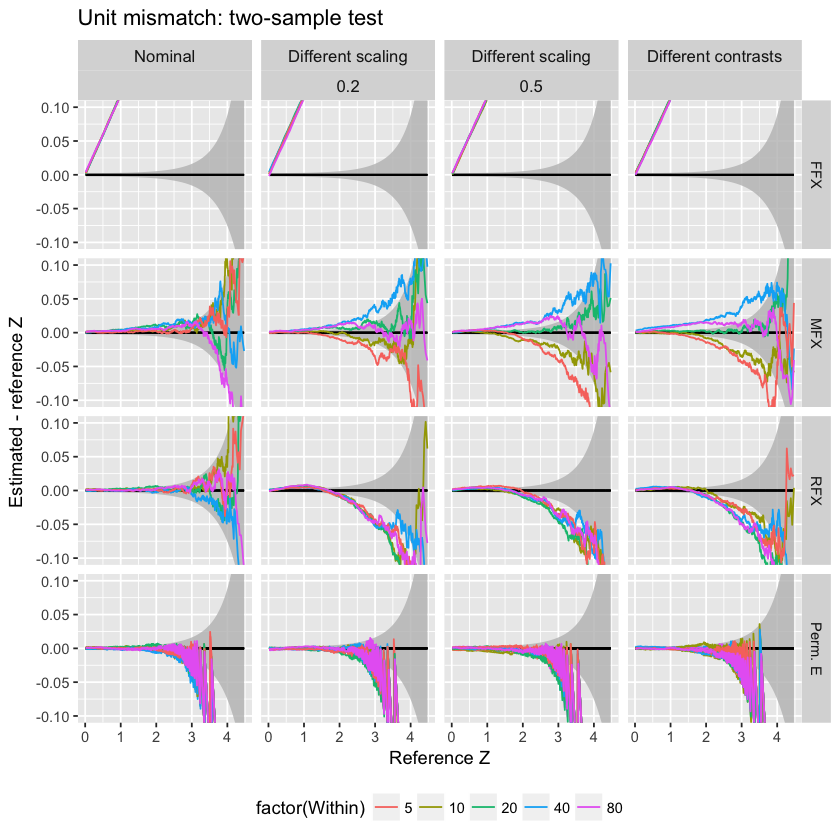

In [9]:
source('plot_lib.R')
source('plot_unit_mismatch.R')
source('plot_blandaldman_z.R')

plot_unit_mismatch(
    subset(best_con_data_2, ((methods %in% c("megaRFX") & Between==1) | !(methods %in% c("megaRFX")))),
    'two-sample test', mult=FALSE, single=TRUE, lim=0.1, 
     filename=file.path("..", "..", "..", "..", "zmeta_paper", "figures", "unitmimatch_test2"), max_z=4.5)

#### Unbalanced two-sample tests)

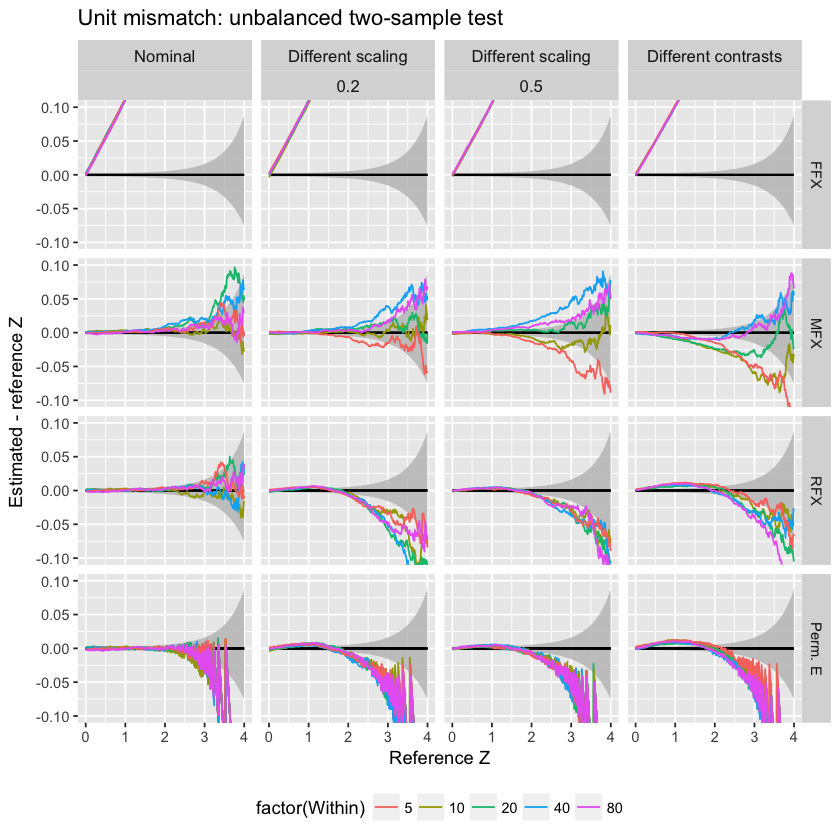

In [10]:
best_con_data_3 <- subset(con_data_3, 
    ((methods %in% c("megaMFX") & Between==1) | 
     (methods %in% c("megaRFX") )  | 
     (methods %in% c("megaFFX_FSL") & Between==0) |
     (methods %in% c("permutCon"))
    ) & nStudies==50)

plot_unit_mismatch(
    subset(best_con_data_3,((methods %in% c("megaRFX") & Between==1) | !(methods %in% c("megaRFX")))),
    'unbalanced two-sample test', mult=FALSE, single=TRUE, lim=0.1,
     filename=file.path("..", "..", "..", "..", "zmeta_paper", "figures", "unitmimatch_test3"), max_z=4)

### 2. Robustness to small sample sizes

In [11]:
con_data_1_small_sample <- subset(con_data_1, 
    ((methods %in% c("megaMFX") & Between==1) | 
     (methods %in% c("megaRFX"))  | 
     (methods %in% c("megaFFX_FSL") & Between==0) |
     (methods %in% c("permutCon"))
    ) & unitMism=="nominal")
con_data_2_small_sample <- subset(con_data_2, 
    ((methods %in% c("megaMFX") & Between==1) | 
     (methods %in% c("megaRFX"))  | 
     (methods %in% c("megaFFX_FSL") & Between==0) |
     (methods %in% c("permutCon"))
    ) & unitMism=="nominal")
con_data_3_small_sample <- subset(con_data_3, 
    ((methods %in% c("megaMFX") & Between==1) | 
     (methods %in% c("megaRFX"))  | 
     (methods %in% c("megaFFX_FSL") & Between==0) |
     (methods %in% c("permutCon"))
    ) & unitMism=="nominal")

Warning message:
“Removed 2270 rows containing missing values (geom_path).”Warning message:
“Removed 950 rows containing missing values (geom_path).”Warning message:
“Removed 950 rows containing missing values (geom_path).”Warning message:
“Removed 2270 rows containing missing values (geom_path).”

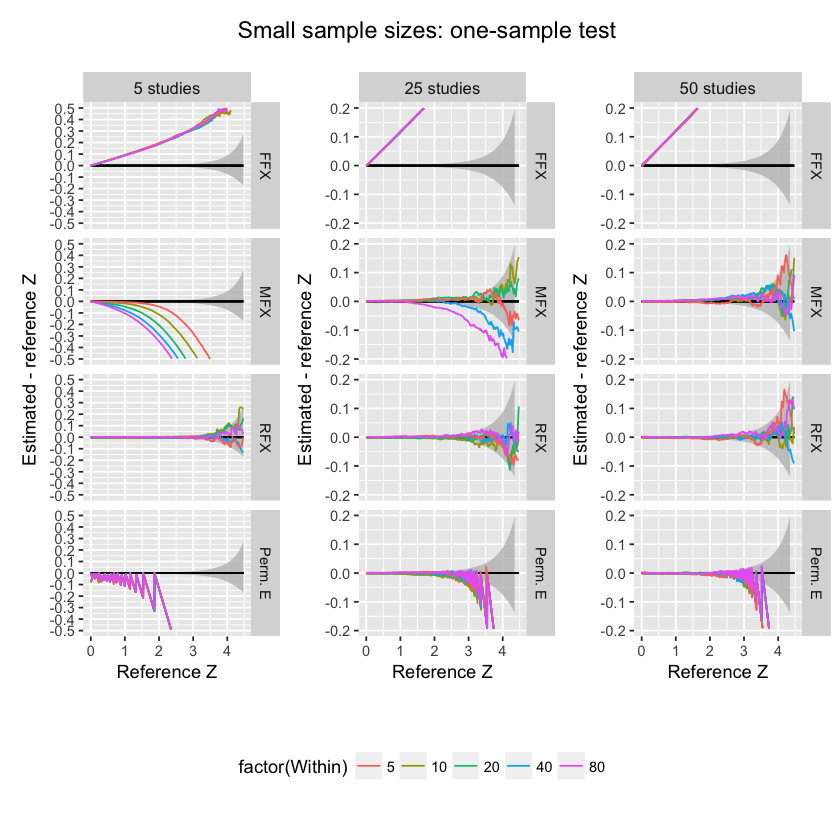

In [12]:
source('plot_lib.R')
source('plot_sample_sizes.R')
source('plot_blandaldman_z.R')
plot_sample_sizes(
    subset(con_data_1_small_sample, ((methods %in% c("megaRFX") & Between==1) | !(methods %in% c("megaRFX")))),
    title='one-sample test', lim=c(0.5, 0.2, 0.2),
    filename=file.path("..", "..", "..", "..", "zmeta_paper", "figures", "samplesizes_test1"), 
    max_z=4.5)

In [13]:
aa=subset(con_data_2_small_sample, ((methods %in% c("megaRFX") & Between==1 & Within==5 & nStudies==100)))
aa=(aa[aa$expectedz>4,])
dim(aa)
(aa$expectedz)
(aa$z_lower-aa$expectedz)
(aa$z_upper-aa$expectedz)

[1] 252  23

[1] 4.758609 4.758609 4.758609 4.758609 4.758609 4.758609 4.758609 4.758609
  [9] 4.758609 4.758609 4.758609 4.758609 4.758609 4.758609 4.758609 4.758609
 [17] 4.758609 4.758609 4.758609 4.758609 4.758609 4.758609 4.758609 4.758609
 [25] 4.758609 4.758609 4.758609 4.758609 4.758609 4.758609 4.616714 4.616714
 [33] 4.616714 4.616714 4.616714 4.616714 4.616714 4.616714 4.616714 4.616714
 [41] 4.616714 4.616714 4.616714 4.616714 4.616714 4.616714 4.616714 4.616714
 [49] 4.616714 4.616714 4.616714 4.616714 4.616714 4.616714 4.616714 4.616714
 [57] 4.616714 4.616714 4.616714 4.616714 4.616714 4.616714 4.616714 4.616714
 [65] 4.616714 4.616714 4.616714 4.531813 4.531813 4.531813 4.531813 4.531813
 [73] 4.531813 4.531813 4.531813 4.531813 4.531813 4.531813 4.531813 4.531813
 [81] 4.531813 4.531813 4.531813 4.531813 4.531813 4.531813 4.531813 4.531813
 [89] 4.531813 4.531813 4.531813 4.470676 4.470676 4.470676 4.470676 4.470676
 [97] 4.470676 4.470676 4.470676 4.470676 4.470676 4.470676 4.470676 4.470676
[105] 4.470676 4.470676 4.470676 4.470676 4.470676 4.422720 4.422720 4.422720
[113] 4.422720 4.422720 4.422720 4.422720 4.422720 4.422720 4.422720 4.422720
[121] 4.422720 4.422720 4.422720 4.422720 4.383181 4.383181 4.383181 4.383181
[129] 4.383181 4.383181 4.383181 4.383181 4.383181 4.383181 4.383181 4.383181
[137] 4.349494 4.349494 4.349494 4.349494 4.349494 4.349494 4.349494 4.349494
[145] 4.349494 4.349494 4.320119 4.320119 4.320119 4.320119 4.320119 4.320119
[153] 4.320119 4.320119 4.320119 4.294055 4.294055 4.294055 4.294055 4.294055
[161] 4.294055 4.294055 4.294055 4.270618 4.270618 4.270618 4.270618 4.270618
[169] 4.270618 4.270618 4.249315 4.249315 4.249315 4.249315 4.249315 4.249315
[177] 4.249315 4.229782 4.229782 4.229782 4.229782 4.229782 4.229782 4.211740
[185] 4.211740 4.211740 4.211740 4.211740 4.194973 4.194973 4.194973 4.194973
[193] 4.194973 4.194973 4.179308 4.179308 4.179308 4.179308 4.164606 4.164606
[201] 4.164606 4.164606 4.164606 4.150752 4.150752 4.150752 4.150752 4.137653
[209] 4.137653 4.137653 4.137653 4.125226 4.125226 4.125226 4.125226 4.113406
[217] 4.113406 4.113406 4.113406 4.102134 4.102134 4.102134 4.091360 4.091360
[225] 4.091360 4.081042 4.081042 4.081042 4.071140 4.071140 4.071140 4.061622
[233] 4.061622 4.061622 4.052458 4.052458 4.052458 4.043623 4.043623 4.043623
[241] 4.035092 4.035092 4.026845 4.026845 4.026845 4.018863 4.018863 4.011130
[249] 4.011130 4.011130 4.003629 4.003629

[1] -0.27064713 -0.27064713 -0.27064713 -0.27064713 -0.27064713 -0.27064713
  [7] -0.27064713 -0.27064713 -0.27064713 -0.27064713 -0.27064713 -0.27064713
 [13] -0.27064713 -0.27064713 -0.27064713 -0.27064713 -0.27064713 -0.27064713
 [19] -0.27064713 -0.27064713 -0.27064713 -0.27064713 -0.27064713 -0.27064713
 [25] -0.27064713 -0.27064713 -0.27064713 -0.27064713 -0.27064713 -0.27064713
 [31] -0.21743054 -0.21743054 -0.21743054 -0.21743054 -0.21743054 -0.21743054
 [37] -0.21743054 -0.21743054 -0.21743054 -0.21743054 -0.21743054 -0.21743054
 [43] -0.21743054 -0.21743054 -0.21743054 -0.21743054 -0.21743054 -0.21743054
 [49] -0.21743054 -0.21743054 -0.21743054 -0.21743054 -0.21743054 -0.21743054
 [55] -0.21743054 -0.21743054 -0.21743054 -0.21743054 -0.21743054 -0.21743054
 [61] -0.21743054 -0.21743054 -0.21743054 -0.21743054 -0.21743054 -0.21743054
 [67] -0.21743054 -0.18925286 -0.18925286 -0.18925286 -0.18925286 -0.18925286
 [73] -0.18925286 -0.18925286 -0.18925286 -0.18925286 -0.18925286 -0.18925286
 [79] -0.18925286 -0.18925286 -0.18925286 -0.18925286 -0.18925286 -0.18925286
 [85] -0.18925286 -0.18925286 -0.18925286 -0.18925286 -0.18925286 -0.18925286
 [91] -0.18925286 -0.17081028 -0.17081028 -0.17081028 -0.17081028 -0.17081028
 [97] -0.17081028 -0.17081028 -0.17081028 -0.17081028 -0.17081028 -0.17081028
[103] -0.17081028 -0.17081028 -0.17081028 -0.17081028 -0.17081028 -0.17081028
[109] -0.17081028 -0.15742783 -0.15742783 -0.15742783 -0.15742783 -0.15742783
[115] -0.15742783 -0.15742783 -0.15742783 -0.15742783 -0.15742783 -0.15742783
[121] -0.15742783 -0.15742783 -0.15742783 -0.15742783 -0.14709704 -0.14709704
[127] -0.14709704 -0.14709704 -0.14709704 -0.14709704 -0.14709704 -0.14709704
[133] -0.14709704 -0.14709704 -0.14709704 -0.14709704 -0.13878400 -0.13878400
[139] -0.13878400 -0.13878400 -0.13878400 -0.13878400 -0.13878400 -0.13878400
[145] -0.13878400 -0.13878400 -0.13189194 -0.13189194 -0.13189194 -0.13189194
[151] -0.13189194 -0.13189194 -0.13189194 -0.13189194 -0.13189194 -0.12604773
[157] -0.12604773 -0.12604773 -0.12604773 -0.12604773 -0.12604773 -0.12604773
[163] -0.12604773 -0.12100389 -0.12100389 -0.12100389 -0.12100389 -0.12100389
[169] -0.12100389 -0.12100389 -0.11658859 -0.11658859 -0.11658859 -0.11658859
[175] -0.11658859 -0.11658859 -0.11658859 -0.11267822 -0.11267822 -0.11267822
[181] -0.11267822 -0.11267822 -0.11267822 -0.10918103 -0.10918103 -0.10918103
[187] -0.10918103 -0.10918103 -0.10602749 -0.10602749 -0.10602749 -0.10602749
[193] -0.10602749 -0.10602749 -0.10316315 -0.10316315 -0.10316315 -0.10316315
[199] -0.10054543 -0.10054543 -0.10054543 -0.10054543 -0.10054543 -0.09814005
[205] -0.09814005 -0.09814005 -0.09814005 -0.09591909 -0.09591909 -0.09591909
[211] -0.09591909 -0.09385959 -0.09385959 -0.09385959 -0.09385959 -0.09194243
[217] -0.09194243 -0.09194243 -0.09194243 -0.09015157 -0.09015157 -0.09015157
[223] -0.08847341 -0.08847341 -0.08847341 -0.08689642 -0.08689642 -0.08689642
[229] -0.08541043 -0.08541043 -0.08541043 -0.08400690 -0.08400690 -0.08400690
[235] -0.08267829 -0.08267829 -0.08267829 -0.08141802 -0.08141802 -0.08141802
[241] -0.08022030 -0.08022030 -0.07908001 -0.07908001 -0.07908001 -0.07799259
[247] -0.07799259 -0.07695408 -0.07695408 -0.07695408 -0.07596068 -0.07596068

[1] 0.69501895 0.69501895 0.69501895 0.69501895 0.69501895 0.69501895
  [7] 0.69501895 0.69501895 0.69501895 0.69501895 0.69501895 0.69501895
 [13] 0.69501895 0.69501895 0.69501895 0.69501895 0.69501895 0.69501895
 [19] 0.69501895 0.69501895 0.69501895 0.69501895 0.69501895 0.69501895
 [25] 0.69501895 0.69501895 0.69501895 0.69501895 0.69501895 0.69501895
 [31] 0.42058639 0.42058639 0.42058639 0.42058639 0.42058639 0.42058639
 [37] 0.42058639 0.42058639 0.42058639 0.42058639 0.42058639 0.42058639
 [43] 0.42058639 0.42058639 0.42058639 0.42058639 0.42058639 0.42058639
 [49] 0.42058639 0.42058639 0.42058639 0.42058639 0.42058639 0.42058639
 [55] 0.42058639 0.42058639 0.42058639 0.42058639 0.42058639 0.42058639
 [61] 0.42058639 0.42058639 0.42058639 0.42058639 0.42058639 0.42058639
 [67] 0.42058639 0.32283777 0.32283777 0.32283777 0.32283777 0.32283777
 [73] 0.32283777 0.32283777 0.32283777 0.32283777 0.32283777 0.32283777
 [79] 0.32283777 0.32283777 0.32283777 0.32283777 0.32283777 0.32283777
 [85] 0.32283777 0.32283777 0.32283777 0.32283777 0.32283777 0.32283777
 [91] 0.32283777 0.27053005 0.27053005 0.27053005 0.27053005 0.27053005
 [97] 0.27053005 0.27053005 0.27053005 0.27053005 0.27053005 0.27053005
[103] 0.27053005 0.27053005 0.27053005 0.27053005 0.27053005 0.27053005
[109] 0.27053005 0.23711047 0.23711047 0.23711047 0.23711047 0.23711047
[115] 0.23711047 0.23711047 0.23711047 0.23711047 0.23711047 0.23711047
[121] 0.23711047 0.23711047 0.23711047 0.23711047 0.21352676 0.21352676
[127] 0.21352676 0.21352676 0.21352676 0.21352676 0.21352676 0.21352676
[133] 0.21352676 0.21352676 0.21352676 0.21352676 0.19579139 0.19579139
[139] 0.19579139 0.19579139 0.19579139 0.19579139 0.19579139 0.19579139
[145] 0.19579139 0.19579139 0.18185213 0.18185213 0.18185213 0.18185213
[151] 0.18185213 0.18185213 0.18185213 0.18185213 0.18185213 0.17053551
[157] 0.17053551 0.17053551 0.17053551 0.17053551 0.17053551 0.17053551
[163] 0.17053551 0.16111740 0.16111740 0.16111740 0.16111740 0.16111740
[169] 0.16111740 0.16111740 0.15312437 0.15312437 0.15312437 0.15312437
[175] 0.15312437 0.15312437 0.15312437 0.14623242 0.14623242 0.14623242
[181] 0.14623242 0.14623242 0.14623242 0.14021164 0.14021164 0.14021164
[187] 0.14021164 0.14021164 0.13489369 0.13489369 0.13489369 0.13489369
[193] 0.13489369 0.13489369 0.13015273 0.13015273 0.13015273 0.13015273
[199] 0.12589185 0.12589185 0.12589185 0.12589185 0.12589185 0.12203553
[205] 0.12203553 0.12203553 0.12203553 0.11852383 0.11852383 0.11852383
[211] 0.11852383 0.11530849 0.11530849 0.11530849 0.11530849 0.11235019
[217] 0.11235019 0.11235019 0.11235019 0.10961653 0.10961653 0.10961653
[223] 0.10708053 0.10708053 0.10708053 0.10471941 0.10471941 0.10471941
[229] 0.10251419 0.10251419 0.10251419 0.10044838 0.10044838 0.10044838
[235] 0.09850791 0.09850791 0.09850791 0.09668062 0.09668062 0.09668062
[241] 0.09495592 0.09495592 0.09332458 0.09332458 0.09332458 0.09177846
[247] 0.09177846 0.09031033 0.09031033 0.09031033 0.08891399 0.08891399

Warning message:
“Removed 3940 rows containing missing values (geom_path).”Warning message:
“Removed 2660 rows containing missing values (geom_path).”Warning message:
“Removed 2660 rows containing missing values (geom_path).”Warning message:
“Removed 3940 rows containing missing values (geom_path).”

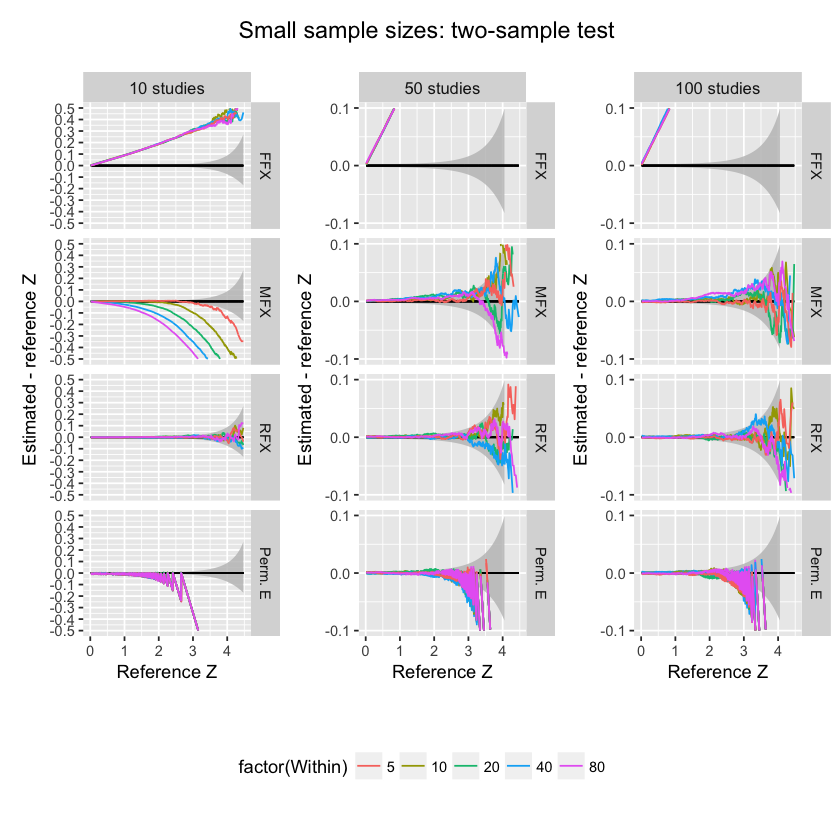

In [14]:
source('plot_blandaldman_z.R')
plot_sample_sizes(
    subset(con_data_2_small_sample, ((methods %in% c("megaRFX") & Between==1) | !(methods %in% c("megaRFX")))),
    title='two-sample test', lim=c(0.5, 0.1, 0.1),
    filename=file.path("..", "..", "..", "..", "zmeta_paper", "figures", "samplesizes_test2"), 
    max_z=4.5)

In [15]:
max(con_data_2_small_sample[con_data_2_small_sample$nStudies==100,]$expectedz)

[1] 4.758609

Warning message:
“Removed 2150 rows containing missing values (geom_path).”Warning message:
“Removed 1060 rows containing missing values (geom_path).”Warning message:
“Removed 1272 rows containing missing values (geom_path).”Warning message:
“Removed 2150 rows containing missing values (geom_path).”

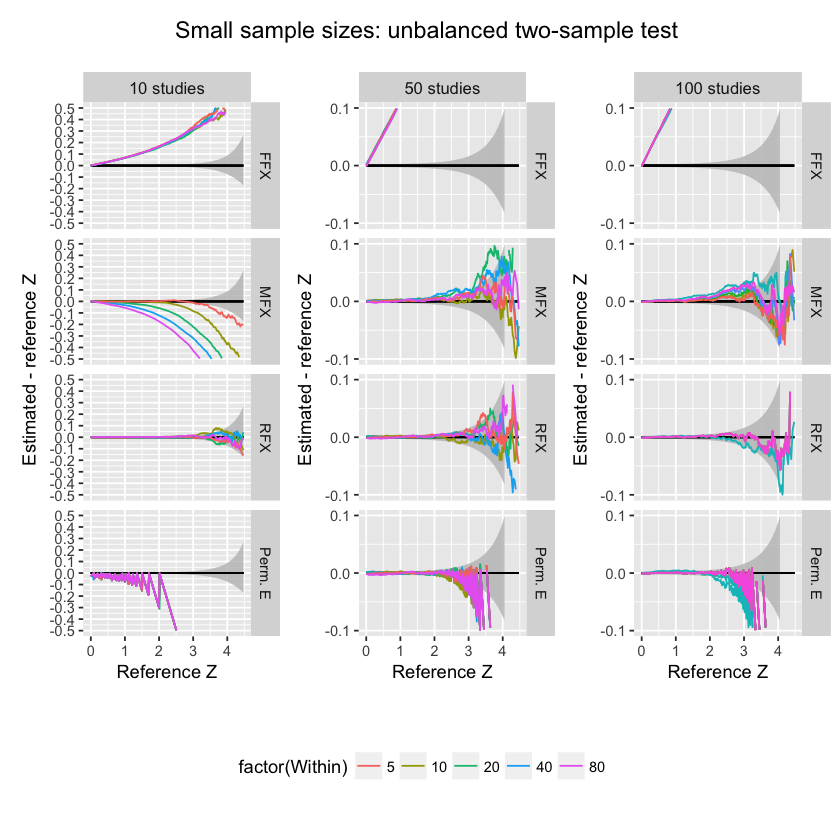

In [16]:
plot_sample_sizes(
    subset(con_data_3_small_sample, ((methods %in% c("megaRFX") & Between==1) | !(methods %in% c("megaRFX")))),
    title='unbalanced two-sample test', lim=c(0.5, 0.1, 0.1),
    filename=file.path("..", "..", "..", "..", "zmeta_paper", "figures", "samplesizes_test3"), max_z=4.5)

### 2. Robustness to violation of underlying assumptions or ...

#### GLM MFX

In [18]:
# con_data_MFX_not_assump <- rbind(subset(con_data_1, 
#     ((methods %in% c("megaMFX") & Between!=1)
#     ) & unitMism=="nominal"),subset(con_data_2, 
#     ((methods %in% c("megaMFX") & Between!=1)
#     ) & unitMism=="nominal"),subset(con_data_3, 
#     ((methods %in% c("megaMFX") & Between!=1)
#     ) & unitMism=="nominal"))

con_data_MFX_not_assump <- subset(con_data_3, 
    ((methods %in% c("megaMFX") & Between!=1)
    ) & unitMism=="nominal")

con_data_MFX_not_assump$nStudiesPerGroup <- con_data_MFX_not_assump$nStudies
con_data_MFX_not_assump$nStudiesPerGroup[con_data_MFX_not_assump$glm>1] <- con_data_MFX_not_assump[con_data_MFX_not_assump$glm>1,]$nStudiesPerGroup/2

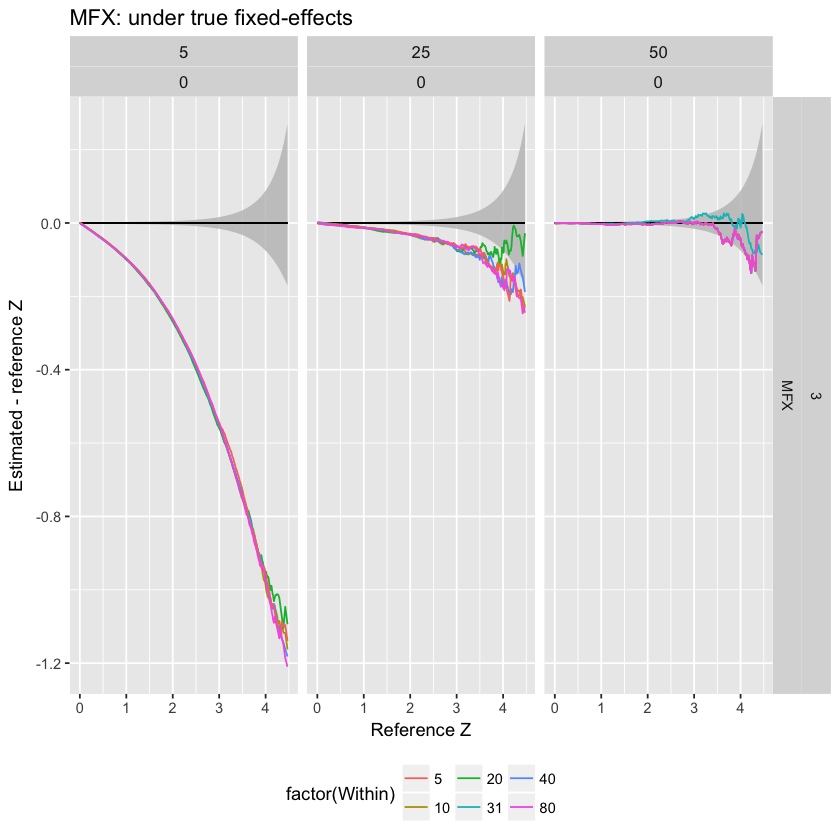

In [21]:
source('plot_blandaldman_z.R')
p <- plot_blandaldman_z(
    list(con_data_MFX_not_assump), 
    glm+methods~nStudiesPerGroup+Between, 
    "MFX: under true fixed-effects", FALSE, NA, NA, max_z=4.5)

# plot_sample_sizes(
#     subset(con_data_MFX_assump, 
#            expectedz<4),
#     title='MFX: underlying assumptions', lim=1.5)

In [ ]:
con_data_MFX_assump <- rbind(subset(con_data_1, 
    ((methods %in% c("megaMFX") & Between==1)
    ) & unitMism=="nominal"),subset(con_data_2, 
    ((methods %in% c("megaMFX") & Between==1)
    ) & unitMism=="nominal"),subset(con_data_3, 
    ((methods %in% c("megaMFX") & Between==1)
    ) & unitMism=="nominal"))

con_data_MFX_assump$nStudiesPerGroup <- con_data_MFX_assump$nStudies
con_data_MFX_assump$nStudiesPerGroup[con_data_MFX_assump$glm>1] <- con_data_MFX_assump[con_data_MFX_assump$glm>1,]$nStudiesPerGroup/2

In [ ]:
p <- plot_blandaldman_z(
    list(con_data_MFX_assump), 
    glm+methods~nStudiesPerGroup, 
    "MFX: under assumptions", FALSE, NA, NA, max_z=4.5)

In [ ]:
# con_data_1_small_sample <- subset(con_data_1, 
#     ((methods %in% c("megaMFX") & Between==1) | 
#      (methods %in% c("megaRFX") & Within==5)  | 
#      (methods %in% c("megaFFX_FSL") & Between==0) |
#      (methods %in% c("permutCon"))
#     ) & unitMism=="nominal")
con_data_1_MFX_assump <- subset(con_data_1, 
    ((methods %in% c("megaMFX") & Between!=1)
    ) & unitMism=="nominal")

In [ ]:
con_data_RFX_not_assump <- rbind(subset(con_data_1, 
    ((methods %in% c("megaRFX"))
    ) & unitMism=="nominal"),subset(con_data_2, 
    ((methods %in% c("megaRFX"))
    ) & unitMism=="nominal"),subset(con_data_3, 
    ((methods %in% c("megaRFX"))
    ) & unitMism=="nominal"))

con_data_RFX_not_assump$nStudiesPerGroup <- con_data_RFX_not_assump$nStudies
con_data_RFX_not_assump$nStudiesPerGroup[con_data_RFX_not_assump$glm>1] <- con_data_RFX_not_assump[con_data_RFX_not_assump$glm>1,]$nStudiesPerGroup/2

In [ ]:
p <- plot_blandaldman_z(
    list(con_data_RFX_not_assump),
    glm+methods+Between~nStudiesPerGroup, 
    "RFX: under varying within-study variance", 
    FALSE, lim=NA, max_z=4.5,
    filename=file.path("..", "..", "..", "..", "zmeta_paper", "figures", "rfx_assump"))

In [ ]:
p <- plot_blandaldman_z(
    list(subset(con_data_3, nStudies==100 & Between==1 & unitMism=="nominal" )),
    methods+unitMism~WithinSame+Within, 
    "RFX: under varying within-study variance", 
    FALSE, lim=0.05, max_z=4,
    filename=file.path("..", "..", "..", "..", "zmeta_paper", "figures", "rfx_assump"))

In [ ]:
num_simu = 30*30*30*38
print(num_simu)
min_p = 1/num_simu
print(min_p)
-qnorm(min_p)
max(con_data_1$expectedz)

In [ ]:
me_data <- rbind(subset(con_data_1, 
    ((methods %in% c("megaRFX"))
    ) & unitMism=="nominal"),subset(con_data_2, 
    ((methods %in% c("megaRFX"))
    ) & unitMism=="nominal"),subset(con_data_3, 
    ((methods %in% c("megaRFX"))
    ) & unitMism=="nominal"))

me_data$nStudiesPerGroup <- me_data$nStudies
me_data$nStudiesPerGroup[me_data$glm>1] <- me_data[me_data$glm>1,]$nStudiesPerGroup/2

p <- plot_blandaldman_z(
    list(me_data),
    glm+Between~nStudiesPerGroup+Within, 
    "RFX: under varying within-study variance", 
    FALSE, lim=NA, max_z=4.5)